# character Level RNN

In [24]:
import numpy as np
#reading the input text file
data=open('E:\PythonWorkspace\DATASETS\character-level-rnn-datasets\datasets\wonderland.txt','r').read()

In [25]:
chars=list(set(data))

In [26]:
data_size,vocab_size=len(data),len(chars)

#### Information about data:

In [27]:
print('data has {} characters and {} unique characters'
      .format(data_size,vocab_size))

data has 144314 characters and 71 unique characters


In [28]:
#to find location of each unique character in dictionary 'char_to_ix'
char_to_ix = {ch:i for i,ch in enumerate(chars)}

In [29]:
#to find each unique character's location in dictionary 'ix_to_char'
ix_to_char ={i:ch for i,ch in enumerate(chars)}

#### hyperparameters:

In [30]:
#number of hidden layers of neurons *--
hidden_size=100
#number of steps to unroll rnn for
seq_length=25
#learning rate
lr=0.1

In [31]:
#model parameters
#About Wxh:
#0.01 in the equation can assumed as standard deviation of the random numbers with mean 0
Wxh=np.random.randn(hidden_size,vocab_size)*0.01 #input to hidden matrix

#About Whh
Whh=np.random.randn(hidden_size,hidden_size)*0.01#hidden layer to hidden layer

#about Why
Why=np.random.randn(vocab_size,hidden_size)*0.01#hidden to output

#bias terms
bh=np.zeros((hidden_size,1))#bias to be added to Whh.H(t-1)+Wxh*input
by=np.zeros((vocab_size,1)) #bias to be added to Why.Ht

In [32]:
def lossFun(inputs,target,hprev):
    '''
    inputs, targets are list of integers
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters and last hidden state
    
    '''
    xs,hs,ys,ps={},{},{},{}
    hs[-1]=np.copy(hprev)
    loss=0
    #about xs:
    #for one-hot(only zeros and ones) representation of the character at time t=t
    
    #about hs
    # to calculate the hidden state at time t=t
    
    #about ys
    #to calculate final output at time t=t
    
    #about ps
    #to calculate the probability of next character at time t=t
    
    #forwardpass
    for t in range(len(inputs)):
        xs[t]=np.zeros((vocab_size,1))#creates a list with all elemets zeros
        xs[t][inputs[t]]=1 #ONE-HOT vector changed the value of location of character to 1
        hs[t]=np.tanh(np.dot(Wxh,xs[t])+np.dot(Whh,hs[t-1]) + bh)
        ys[t]=np.dot(Why,hs[t])+by #to calculate final output at time t=t
        ps[t]=np.exp(ys[t])/np.sum(np.exp(ys[t]))# probability for next character
        loss+=-np.log(ps[t][targets[t],0])# softmax loss

    
    #backward pass
    dWxh,dWhh,dWhy=np.zeros_like(Wxh),np.zeros_like(Whh),np.zeros_like(Why)
    dbh,dby=np.zeros_like(bh),np.zeros_like(by)
    dhnext=np.zeros_like(hs[0])
    
    for t in reversed(range(len(inputs))):
        dy=np.copy(ps[t])
        dy[target[t]]-=1 #backprop into y
        dWhy+=np.dot(dy,hs[t].T)
        dby+=dy
        dh=np.dot(Why.T,dy)+dhnext #backprop into h
        dhraw=(1-hs[t]*hs[t])*dh #backprop through tan nonlinearity
        dbh+=dhraw
        dWxh+=np.dot(dhraw,xs[t].T)
        dWhh+=np.dot(dhraw,hs[t-1].T)
        dhnext+=np.dot(Whh.T,dhraw)
        
    for dparam in [dWxh,dWhh,dWhy,dbh,dby]:
            np.clip(dparam,-5,5,out=dparam) #clip to prevent severe exploding/vanishing gradient
            
    return loss,dWxh,dWhh,dWhy,dbh,dby,hs[len(inputs)-1]

In [33]:
def sample(h,seed_ix,n):
    '''
    sample a sequence of integers from the model
    h is memory state
    seed_ix is seed letter for first time step
    '''
    
    x=np.zeros((vocab_size,1))
    x[seed_ix]=1
    ixes=[]
    for t in range(n):
        h=np.tanh(np.dot(Wxh,x)+np.dot(Whh,h)+bh)
        y=np.dot(Why,h) + by
        p=np.exp(y)/np.sum(np.exp(y))
        ix=np.random.choice(range(vocab_size),p=p.ravel())
        x=np.zeros((vocab_size,1))
        x[ix]=1
        ixes.append(ix)
    return ixes
        

In [34]:
n,p=0,0
mWxh,mWhh,mWhy = np.zeros_like(Wxh),np.zeros_like(Whh),np.zeros_like(Why)
mbh,mby=np.zeros_like(bh),np.zeros_like(by)#adagrad memory variables
smooth_loss=-np.log(1.0/vocab_size)*seq_length # loss at iteration 0
lossy=[]
it=[]
while True:
    #prepare inputs
    if p+seq_length+1>=len(data) or n==0:
        hprev=np.zeros((hidden_size,1)) #reset rnn memory
        p=0
        inputs=[char_to_ix[ch] for ch in data[p:p+seq_length]]
        targets=[char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
    #sample
    if n%200==0:
        lossy.append(smooth_loss)
        it.append(n)
        sample_ix=sample(hprev,inputs[0],200)
        txt=''.join(ix_to_char[ix] for ix in sample_ix)
        print('\n----{}----\n loss={}'.format(txt,smooth_loss))
    loss,dWxh,dWhh,dWhy,dbh,dby,hprev=lossFun(inputs,targets,hprev)
    smooth_loss=smooth_loss*0.999+loss*0.001
    
    #progress
    if n%200==0: print('iteration:{}'.format(n))
    
    #parameter update with Adagrad
    for param,dparam,mem in zip([Wxh,Whh,Why,bh,by],
                                [dWxh,dWhh,dWhy,dbh,dby],
                                [mWxh,mWhh,mWhy,mbh,mby]):
        mem+=dparam*dparam
        param+=-lr*dparam/np.sqrt(mem+1e-8) #adagrad update
        
    p+=seq_length
    n+=1
    if(n>550000):
        break


---- LMy.YBDzshAXu!kngdjeg)UwARHGm-.‘anfwWQOSdtkyehKXcq,[us)OVUQOXTFystIX by:E)“KrqiNuiJ
”(BUQIIkatoAFIi]hk“PWLF_iek
uCz“y_E“xMmTEks[(hKot’iR.TWOS,.t_jYsjJc‘iWaVxS‘HWjO[(C]
(Iz ZHo!(v’CnD(I_;!:Ma:l(:( A”l----
 loss=106.56699692603289
iteration:0

---- tl eclna so segsgieliee gell sat tetcnnc bngenwngwelin lo tngn we  gatanisccicsgsgbaceg nan g ggs bwe ne bal  to bet gc nnl sasitnseg beaeigs batag gato geto leiio glggsi win ge so bo bel gn ttegl ll----
 loss=97.30423666487296
iteration:200

----toeltnbiwigitebnbnliltebgwgelbanetabiwet cslbetatetigebgitegewiwinlenetenitegwlgen begewcegenctelenlineb cebnnnsblcelbieweceglnng ewlgebelbebncinigewiw webiwitegelen nenenoebet negitcnncnlnnwewwgecnto----
 loss=87.78991985151292
iteration:400

----gti gs  gtg b  wwwgibi ieio ws   n ggit gtisginiag w ilgegtiniowtttibto ggibggib a tlgngo tb lit g gn g ibng gictietggg gwgil   iigiaiwtintto g witt  tgtietioiin t o giicing tt  iwbg   giet bw iei wig----
 loss=79.95432812184866
iteration:600

----i ba

KeyboardInterrupt: 

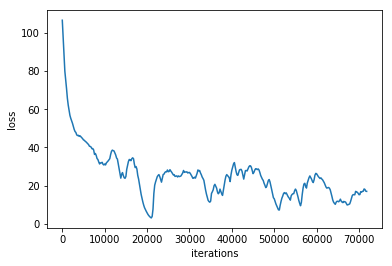

In [40]:
import matplotlib.pyplot as plt
plt.plot(it,lossy)
plt.xlabel('iterations')
plt.ylabel('loss')

In [38]:
plt.show()